In [1]:
!pip install pandas==1.5.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 45.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4


In [2]:
##open b3 file

import pickle as pkl
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import gdown

from matplotlib.legend import Legend

b3file = '/content/drive/MyDrive/b3/data/b3data_.pickle'
fffile = '/content/drive/MyDrive/b3/data/freefloat.csv' 

#b3file =  'https://drive.google.com/uc?id=1JtSz0ZT7-YYZ1qLJBsQ5xzxSjEKOPcIr' 
#fffile =  'https://drive.google.com/uc?id=1dERVI3XEgYjsMBelfAVZjY0Au_Xqm9zo' 


def download_file(url, output):
  gdown.download(url, output, quiet=False)
  return output

def load_data(b3_path, freefloat_path):

  #b3data = download_file(b3_path, './temp/b3file.pkl')
  #freefloatdata = download_file(freefloat_path,'./temp/freefloat.csv')
  b3data = b3_path
  freefloatdata = freefloat_path
  
    
  data = {}
  with open(b3data, 'rb') as f:
    data = pkl.load(f)



  data['LoanBalance']['DnrAvrgRate']  = data['LoanBalance']['DnrAvrgRate'].replace('\%','',regex=True).replace('\,','.',regex=True).astype(float)/100

  ff = pd.read_csv(filepath_or_buffer=freefloatdata,header=0, sep=';')
  ff = ff.astype({'TickerSymbol':'str','FreeFloatQty':'int'})
  ff.rename(columns = {'TickerSymbol': 'TckrSymb'}, inplace = True)
  asof = max(data['marketdays'])

  return data, ff, asof

def selectStock(stock):
  stock_df = mktdata[mktdata['TckrSymb']==stock]
  stock_lend = lend[lend['TckrSymb']==stock]
  stock_loan = loan[loan['TckrSymb']==stock]

  return stock_df, stock_lend, stock_loan


def dataPreparation(s_mkt, s_lend, s_loan, ff):
  s_lend = s_lend.assign(mean_qt = round(s_lend['BalQty'].mean(),3))
  s_lend = s_lend.assign(mean_vl = round(s_lend['BalVal'].mean(),3))
  s_lend = s_lend.assign(_qt     = round(((s_lend['BalQty']/s_lend['mean_qt'])),3))
  s_lend = s_lend.assign(_vl     = round(((s_lend['BalVal']/s_lend['mean_vl'])),3))

  s_aux = s_lend.merge(s_mkt, on = 'RptDt')

  
  s_aux = s_aux.assign(Porc_Short_Vol_Qt = round(s_aux['BalQty']/s_aux['FinInstrmQty'],3))
  s_aux = s_aux.assign(Porc_Short_Vol_Fin = round(s_aux['BalVal']/s_aux['NtlFinVol'],3))

  cols = ['RptDt','TckrSymb_x','LastPric','BalQty','FinInstrmQty','Porc_Short_Vol_Qt','_qt','NtlFinVol','BalVal','Porc_Short_Vol_Fin','_vl']

  s_aux =s_aux[cols]
  s_aux.rename(columns = {'TckrSymb_x': 'TckrSymb', 'BalQty':'Lended', 'FinInstrmQty': 'Vol', 'Porc_Short_Vol_Qt': 'LendedVol_%'}, inplace = True)


  s_aux = s_aux.merge(ff, on = 'TckrSymb')


  s_loan = s_loan.groupby(['RptDt','TckrSymb']).aggregate({'QtyCtrctsDay':'sum','QtyShrDay':'sum','ValCtrctsDay':'sum','DnrAvrgRate':'mean'}).reset_index()

  s_aux = s_aux.merge(s_loan, on = 'RptDt')
  cols = ['RptDt','TckrSymb_x','LastPric','Lended','Vol','LendedVol_%','FreeFloatQty','DnrAvrgRate'] #,'_qt','NtlFinVol','BalVal','Porc_Short_Vol_Fin','_vl'
  s_aux =s_aux[cols]


  factor= 1000000
  s_aux['Lended'] = s_aux['Lended']/factor
  s_aux['Vol'] = s_aux['Vol']/factor
  s_aux['FreeFloatQty'] = s_aux['FreeFloatQty']/factor
  s_aux['MaxLend'] = s_aux['FreeFloatQty']*0.25 # regra B3

  s_aux['%Lended'] = s_aux['Lended']/s_aux['MaxLend']
  return s_aux


def plot(s_aux, s_rsi, mvg):
 
  
  fig, (ax1,ax2,ax3,ax4)  = plt.subplots(1,4)
    
  s_aux[['Lended','Vol']].plot(kind='bar', ax = ax1, width = 0.5,  figsize=(40,10))
  s_aux[['LendedVol_%']].plot(secondary_y=True, ax = ax1, color='gray')
  ax1.set_xticklabels(s_aux['RptDt'].dt.date, rotation=45)
  ax1.invert_xaxis()
  ax1.set_yscale('log')

  
  s_aux[['%Lended']].plot(ax = ax2, color='red')
  s_aux[['DnrAvrgRate']].plot(secondary_y=True,ax = ax2, color='blue')
  ax2.set_xticklabels(s_aux['RptDt'].dt.date, rotation=45)
  ax2.invert_xaxis()


  mvgs = [ 'mavg_' + str(x)  for x in mvg]
  mvgs.append('LastPric')
  s_rsi[mvgs].plot(ax = ax3)
  ax3.set_xticklabels(s_rsi['RptDt'].dt.date, rotation=45)
  ax3.invert_xaxis()


  s_rsi[['rsi']].plot(ax = ax4, color='black')
  ax4.set_xticklabels(s_rsi['RptDt'].dt.date, rotation=45)
  ax4.invert_xaxis()


  ax1.title.set_text(stock)
  ax2.title.set_text('% of the available to lend')
  ax3.title.set_text('Stock Closing Price')
  ax4.title.set_text('RSI')


  plt.show()





In [3]:
def extend_dates(n, unq):

  mi, ma = min(unq), max(unq)
  if n < 0:
    a = mi + np.timedelta64(n,'D')
    b = mi

  if n >= 0:
    a = ma + np.timedelta64(1,'D')
    b = ma + np.timedelta64(n+1,'D')

  return np.arange(a, b, np.timedelta64(1, "D"))   


def rsi(df, n=9):

  df = df.assign(change = df['LastPric'] - df['LastPric_y'])

  df['gain'] = df['change'].apply(lambda x: x if x > 0 else 0.0)
  df['loss'] = df['change'].apply(lambda x: abs(x) if x < 0 else 0.0)


  df['avg_gain'] = None
  df['avg_loss'] = None
  df['rsi'] = None

  upper = max(df.index)
  lower = upper - n

  if lower < 0:
    df.loc[upper, 'rsi'] = -1 


  #RSI = [100 - (100/{1+ RS})].

  while lower > 0:
    lower = upper - n
    u = upper - 1
    v = df.loc[lower: u]
    df.loc[upper,'avg_gain'] = ((v['gain'].mean())*(n-1)+df.loc[upper,'gain'])/n
    df.loc[upper,'avg_loss'] = ((v['loss'].mean())*(n-1)+df.loc[upper,'loss'])/n
    df.loc[upper, 'rsi']     = round((100 - (100/(1+ (df.loc[upper,'avg_gain']/df.loc[upper,'avg_loss'])))),2)
    upper -= 1   


  c = ['RptDt','TckrSymb','OpenPric','MaxPric','MinPric','LastPric','OscnPctg','LastPric_y','OscnPctg_y','rsi']
  return df[c]

def mavg(df, n=[3,7,14,21]):

  for i in n:
    upper = max(df.index)
    lower = upper - i

    if lower < 0:
      df.loc[upper,'mavg_' + str(i)] = -1


    #RSI = [100 - (100/{1+ RS})].

    while lower > 0:
      lower = upper - i
      u = upper - 1 #VALIDAR ISSO (USA O FECHAMENTO DO DIA PARA CALCULAR A MÉDIA?)
      v = df.loc[lower: upper]
      df.loc[upper,'mavg_' + str(i)] = round(v['LastPric'].mean(),2)
      upper -= 1  
  return df


def prepareDf(s_mkt):

  s_mkt = s_mkt.assign(OpenPric =  round(s_mkt['LastPric']*(1-s_mkt['OscnPctg']/100),2))
  s_mkt.reset_index(inplace=True)
  s_mkt = s_mkt[['RptDt','TckrSymb','OpenPric','MaxPric','MinPric','LastPric', 'FinInstrmQty',	'NtlFinVol', 'OscnPctg']]

  s_mkt[['RptDt','LastPric']]

  uqn = s_mkt.RptDt.unique()
  n = -1
  ext_dt = extend_dates(n, uqn)

  z = pd.DataFrame(sorted(np.append(uqn,ext_dt)),columns=['RptDt'])
  z = z.assign(prevIdx = pd.RangeIndex(start=z.index.start+n,stop=z.index.stop+n,step=1))
  z.reset_index(inplace=True)

  zz = pd.merge(z, z, how="inner", on=None, left_on='prevIdx', right_on='index', left_index=False, right_index=False, sort=True, suffixes=("", "_y"), copy=True, indicator=False, validate=None)
  zz = zz[['RptDt','RptDt_y']]
  zz.columns = ['RptDt','PrevRptDt']

  sss = pd.merge(s_mkt, zz, how="inner", on=None, left_on='RptDt', right_on='RptDt', left_index=False, right_index=False, sort=True, suffixes=("", "_y"), copy=True, indicator=False, validate=None)
  ssss = pd.merge(sss, sss, how="left", on=None, left_on='PrevRptDt', right_on='RptDt', left_index=False, right_index=False, sort=True, suffixes=("", "_y"), copy=True, indicator=False, validate=None)
  ssss = ssss[['RptDt','TckrSymb','OpenPric','MaxPric','MinPric','LastPric','OscnPctg','LastPric_y','OscnPctg_y']]

  return ssss

In [4]:
data, ff, asof = load_data(b3file,fffile)

## filter only stocks
_ctr = ['TradeInformationConsolidated','LendingOpenPosition', 'LoanBalance']

mktdata = data['TradeInformationConsolidated'][data['TradeInformationConsolidated']['SgmtNm']=='CASH']
lend = data['LendingOpenPosition'][data['LendingOpenPosition']['TckrSymb'].isin(mktdata['TckrSymb'].unique())]
loan = data['LoanBalance'][data['LoanBalance']['TckrSymb'].isin(mktdata['TckrSymb'].unique())]


stocks = mktdata['TckrSymb'].unique()

<ipython-input-2-c522f2247af6>:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(s_aux['RptDt'].dt.date, rotation=45)
<ipython-input-2-c522f2247af6>:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(s_rsi['RptDt'].dt.date, rotation=45)
<ipython-input-2-c522f2247af6>:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(s_rsi['RptDt'].dt.date, rotation=45)


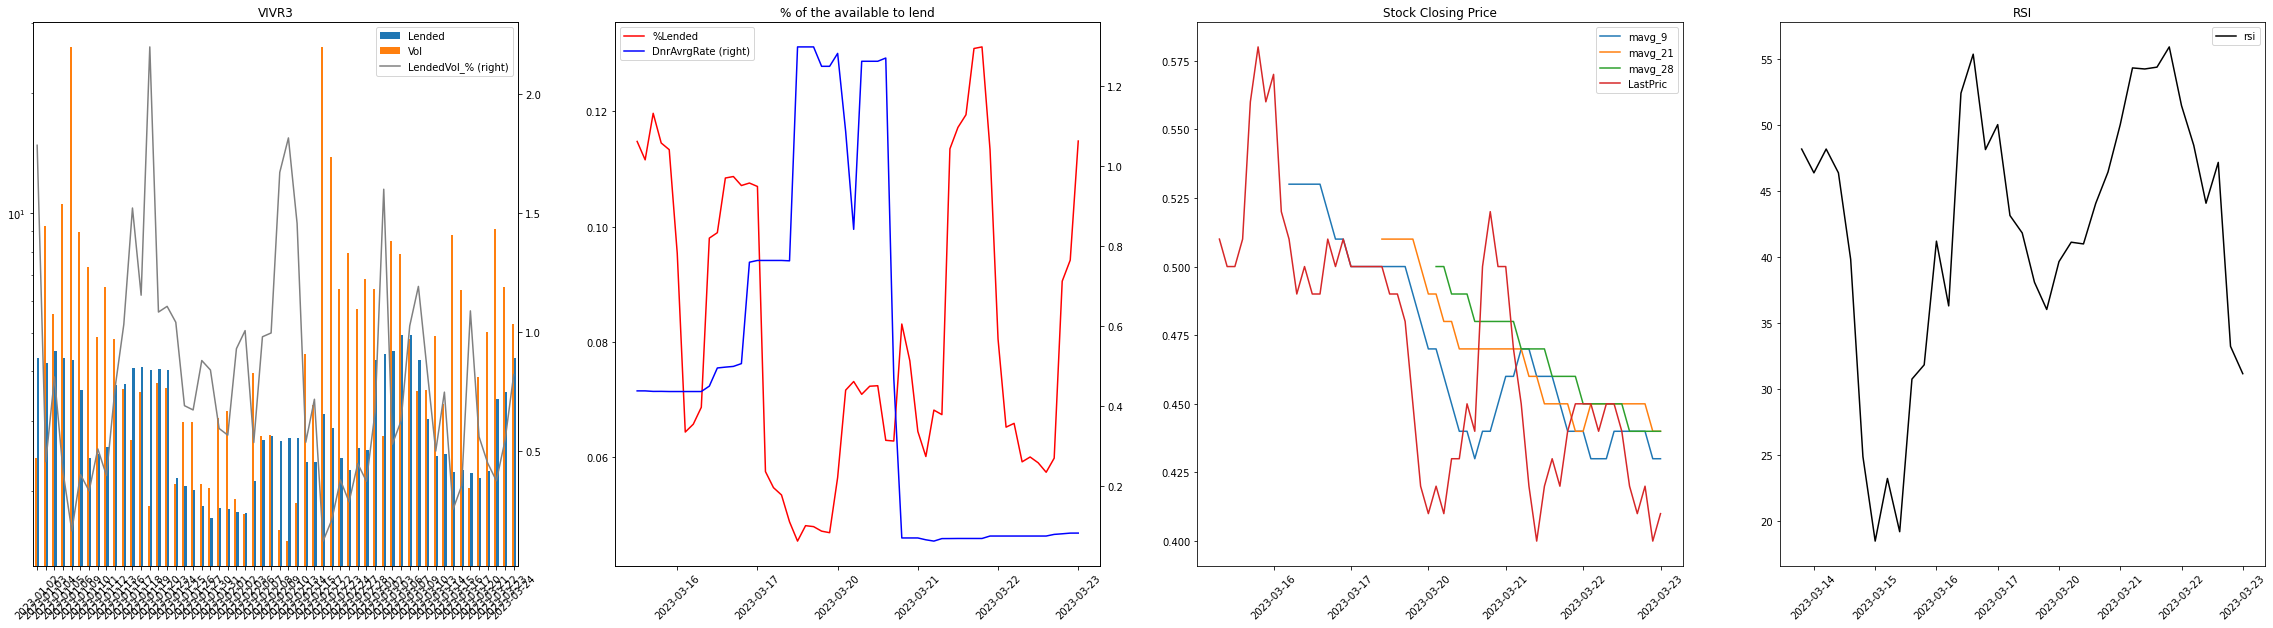

In [5]:
stock = 'VIVR3'
mvg = [9,21,28]
s_mkt, s_lend, s_loan = selectStock(stock)
s_aux = dataPreparation(s_mkt, s_lend, s_loan, ff) # MERGE RENT WITH MARKET DATA
mavg_df = mavg(rsi(prepareDf(s_mkt),21), mvg).sort_values(by='RptDt',ascending=False)  # adding stuff
mavg_df.reset_index(inplace=True)

plot(s_aux, mavg_df, mvg)




In [6]:
output_csv =  '/content/drive/MyDrive/b3/data/{asof}_data.csv'

df = pd.DataFrame()

for s in stocks:
  stock = s
  mvg = [7,14,21]
  rsi_v = 21
  s_mkt, s_lend, s_loan = selectStock(stock)
  s_aux = dataPreparation(s_mkt, s_lend, s_loan, ff) # MERGE RENT WITH MARKET DATA
  p_rsi = rsi(prepareDf(s_mkt),rsi_v)
  mavg_df = mavg(p_rsi, mvg).sort_values(by='RptDt',ascending=False)  # adding stuff

  mavg_df.reset_index(inplace=True)
  df_to_export = mavg_df.iloc[0:1]
  df = pd.concat([df,df_to_export], ignore_index = True)


df.to_csv(output_csv.replace('{asof}',str(asof)))

df

<ipython-input-3-4b6fbad0885b>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[upper,'mavg_' + str(i)] = round(v['LastPric'].mean(),2)
<ipython-input-3-4b6fbad0885b>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[upper,'mavg_' + str(i)] = round(v['LastPric'].mean(),2)
<ipython-input-3-4b6fbad0885b>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,index,RptDt,TckrSymb,OpenPric,MaxPric,MinPric,LastPric,OscnPctg,LastPric_y,OscnPctg_y,rsi,mavg_7,mavg_14,mavg_21
0,57,2023-03-24,5GTK11,78.72,78.40,77.83,78.40,-0.41,78.73,2.15,52.46,78.06,77.56,77.72
1,49,2023-03-24,A1AP34,36.56,36.36,36.20,36.26,-0.82,36.56,-5.01,14.12,38.59,41.04,42.91
2,53,2023-03-24,A1BB34,43.29,42.32,42.32,42.32,-2.30,43.32,-0.91,39.36,43.06,43.32,43.34
3,57,2023-03-24,A1DM34,394.40,402.40,394.80,400.00,1.40,394.46,-2.85,41.31,400.71,403.87,408.45
4,51,2023-03-24,A1EG34,22.48,21.44,21.44,21.44,-4.83,22.53,-0.30,22.45,22.36,23.91,24.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,0,2023-01-05,S2QS34,17.61,18.94,18.94,18.94,7.00,NaN,NaN,-1,-1.00,-1.00,-1.00
1821,2,2023-01-04,AESB1,0.22,0.25,0.16,0.19,-13.63,0.22,-8.33,-1,-1.00,-1.00,-1.00
1822,0,2023-01-04,BPFR39,53.01,53.77,53.77,53.77,1.42,NaN,NaN,-1,-1.00,-1.00,-1.00
1823,0,2023-01-04,I1PG34,232.04,271.67,234.22,271.61,14.57,NaN,NaN,-1,-1.00,-1.00,-1.00


In [7]:
df[df.RptDt=='2023-02-13']

,index,RptDt,TckrSymb,OpenPric,MaxPric,MinPric,LastPric,OscnPctg,LastPric_y,OscnPctg_y,rsi,mavg_7,mavg_14,mavg_21
1732,0,2023-02-13,BFXH39,36.59,36.59,36.59,36.59,0.00,NaN,NaN,-1,-1.0,-1.00,-1.00
1733,6,2023-02-13,DMFN3,14.61,14.61,14.61,14.61,0.00,14.61,0.00,-1,-1.0,-1.00,-1.00
1734,30,2023-02-13,MGLG11,39.76,41.35,39.80,40.99,3.01,39.79,-0.52,49.33,40.7,40.64,40.66
1735,0,2023-02-13,MRSA5B,20.95,27.00,27.00,27.00,22.39,NaN,NaN,-1,-1.0,-1.00,-1.00
1736,1,2023-02-13,P1NR34,224.47,289.45,289.45,289.45,22.45,237.51,-4.22,-1,-1.0,-1.00,-1.00
1737,0,2023-02-13,SOND6,32.35,32.35,32.35,32.35,0.00,NaN,NaN,-1,-1.0,-1.00,-1.00


In [8]:
def download_file(url, out):
  filename = wget.download(url, out=out)
  return filename

In [9]:
x = download_file(b3file, './b3file.pkl')

b3file

NameError: ignored

In [ ]:
with open(x, 'rb') as f:
  data = pkl.load(f)

In [ ]:
import gdown

#url = 'https://drive.google.com/uc?id=0B9P1L--7Wd2vNm9zMTJWOGxobkU'
url = b3file
output = './temp/b3file.pkl'
gdown.download(url, output, quiet=False)

##deprecated ---  

# import numpy as np
# z = pd.DataFrame(sorted(np.append(s_mkt.RptDt.unique(),np.datetime64('2022-12-30'))),columns=['RptDt'])
# z = z.assign(prevIdx = pd.RangeIndex(start=z.index.start-1,stop=z.index.stop-1,step=1))
# z.reset_index(inplace=True)

# zz = pd.merge(z, z, how="inner", on=None, left_on='prevIdx', right_on='index', left_index=False, right_index=False, sort=True, suffixes=("_x", "_y"), copy=True, indicator=False, validate=None)
# zz = zz[['RptDt_x','RptDt_y']]
# zz.columns = ['RptDt','PrevRptDt']
# sss = pd.merge(ss, zz, how="inner", on=None, left_on='RptDt', right_on='RptDt', left_index=False, right_index=False, sort=True, suffixes=("", "_y"), copy=True, indicator=False, validate=None)
# ssss = pd.merge(sss, sss, how="left", on=None, left_on='PrevRptDt', right_on='RptDt', left_index=False, right_index=False, sort=True, suffixes=("", "_y"), copy=True, indicator=False, validate=None)
# ssss = ssss[['RptDt','TckrSymb','MinPric','MaxPric','LastPric','FinInstrmQty',	'NtlFinVol',	'OscnPctg','LastPric_y','OscnPctg_y','OpenPric']]

# ssss = ssss.assign(OpenPric2 =  round(ssss['LastPric_y']*(1-ssss['OscnPctg_y']/100),3))
# ssss = ssss.assign(OpenPric3 =  round(ssss['LastPric']*(1-ssss['OscnPctg_y']/100),3))
# ssss = ssss.assign(OpenPric4 =  round(ssss['LastPric_y']*(1-ssss['OscnPctg']/100),3))
# ssss = ssss.assign(OpenPric5 =  round(ssss['LastPric_y']*(1+ssss['OscnPctg_y']/100),3))
# ssss = ssss.assign(OpenPric6 =  round(ssss['LastPric']*(1+ssss['OscnPctg_y']/100),3))
# ssss = ssss.assign(OpenPric7 =  round(ssss['LastPric_y']*(1+ssss['OscnPctg']/100),3)) *texto em itálico*